In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

## Load Data

### Load the data and split them to train and test

In [4]:
claps = pd.read_csv('./data\\clap\\data.csv', header=None).to_numpy()
hi_hats = pd.read_csv('./data\\hi-hat\\data.csv', header=None).to_numpy()
kicks = pd.read_csv('./data\\kick\\data.csv', header=None).to_numpy()
snares = pd.read_csv('./data\\snare\\data.csv', header=None).to_numpy()

sounds_X = [claps, hi_hats, kicks, snares]
sound_X_names = ['clap', 'hi hat', 'kick', 'snare']

X_train = None
y_train = None
X_test = None
y_test = None

# split data to train and test
for i in range(len(sounds_X)):
    # temp store the one hot vectors of each sound
    temp_y = []

    # create the one hot vector
    hot_vector = [1 if j == i else 0 for j in range(len(sounds_X))]

    # add one hot vector to y data for the specific sound
    for j in range(sounds_X[i].shape[0]):
            temp_y.append(hot_vector)

    # convert temp list to a numpy array of shape (data.shape[0], 4)
    temp_y = np.array(temp_y)
    #print(sounds_X[i].shape, " ", temp_y.shape)

    # split the data
    sound_X_train, sound_X_test, sound_y_train, sound_y_test = train_test_split(sounds_X[i], temp_y, test_size=0.33, random_state=42)

    # concatenate to train, test data
    if i == 0:
        X_train = sound_X_train
        X_test = sound_X_test
        y_train = sound_y_train
        y_test = sound_y_test
    else:
        X_train = np.concatenate((X_train, sound_X_train))
        X_test = np.concatenate((X_test, sound_X_test))
        y_train = np.concatenate((y_train, sound_y_train))
        y_test = np.concatenate((y_test, sound_y_test))

print("X train:", X_train.shape, "\nX test:", X_test.shape, "\ny train:", y_train.shape, "\ny test:", y_test.shape)


X train: (10172, 1131) 
X test: (5014, 1131) 
y train: (10172, 4) 
y test: (5014, 4)


## 1. PCA

In [5]:
def eigsort(A):
    eigvals, U = np.linalg.eig(A)
    # sort eigenvalues in descending order
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    #re-arrange the eigenvectors
    U = U[:,order]
    return U, eigvals

In [6]:
def pca(X, M):

    # get the mean of every column (feature) of matrix X
    mu = X.mean(axis=0).reshape((1,-1))

    # subtract the mean from X
    normalized_X = (X-mu)

    # calculate the Covariance matrix
    S = (1/X.shape[0]) * normalized_X.T.dot(normalized_X)

    # calcualte the eigenvectors and eigenvalues of the covariance matrix
    eigvectors, eigvals = eigsort(S)

    # Keep the first M columns of the eigenvectors
    U = eigvectors[:,:M]
    # Keep the first M values of the eigenvalues
    Lambdas = eigvals[:M]
    print( X.shape, U.shape, Lambdas.shape )

    # calculate Z = U * X
    Z = normalized_X.dot(U)
    return Z, U, Lambdas, mu

In [30]:
M = 50
# pca for train data
X_train_pca, eigvecs_train, eigvals_train, mu_train = pca(X_train, M)
X_train_rec = X_train_pca.dot(eigvecs_train.T) + mu_train
# pca for test data
X_test_pca, eigvecs_test, eigvals_test, mu_test = pca(X_test, M)
X_test_rec = X_test_pca.dot(eigvecs_test.T) + mu_test

(10172, 1131) (1131, 50) (50,)
(5014, 1131) (1131, 50) (50,)


In [31]:
def plot_data(X, y, ind =[]):
    if not len(ind):
        ind = np.random.permutation(X.shape[0])
    f = plt.figure()
    f.set_figheight(10)
    f.set_figwidth(18)
    for i in range(20):
        plt.subplot(5, 4, i+1)
        plt.xlabel(sound_X_names[np.where(y[ind[i]]==1)[0][0]])
        plt.imshow(X[ind[i]].reshape(13, -1).real, cmap=plt.cm.gray)

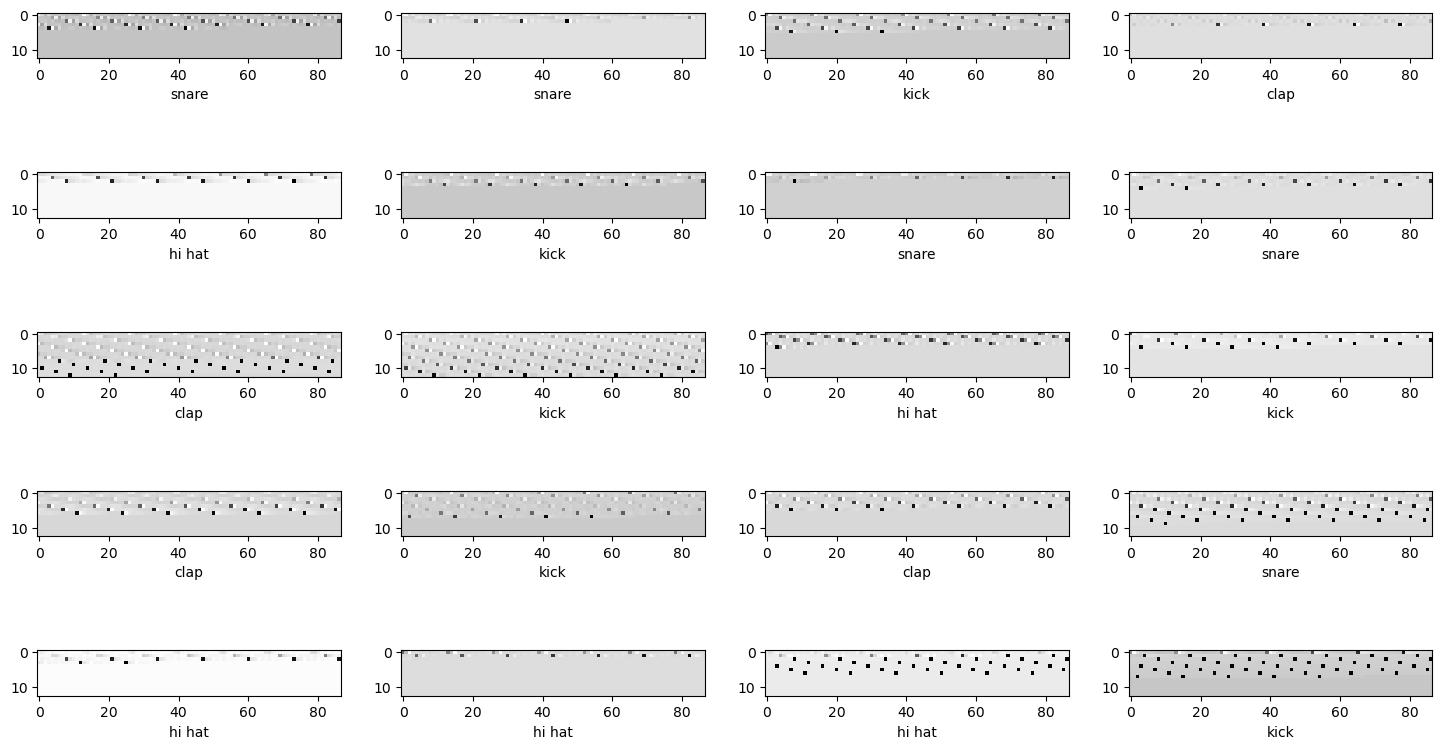

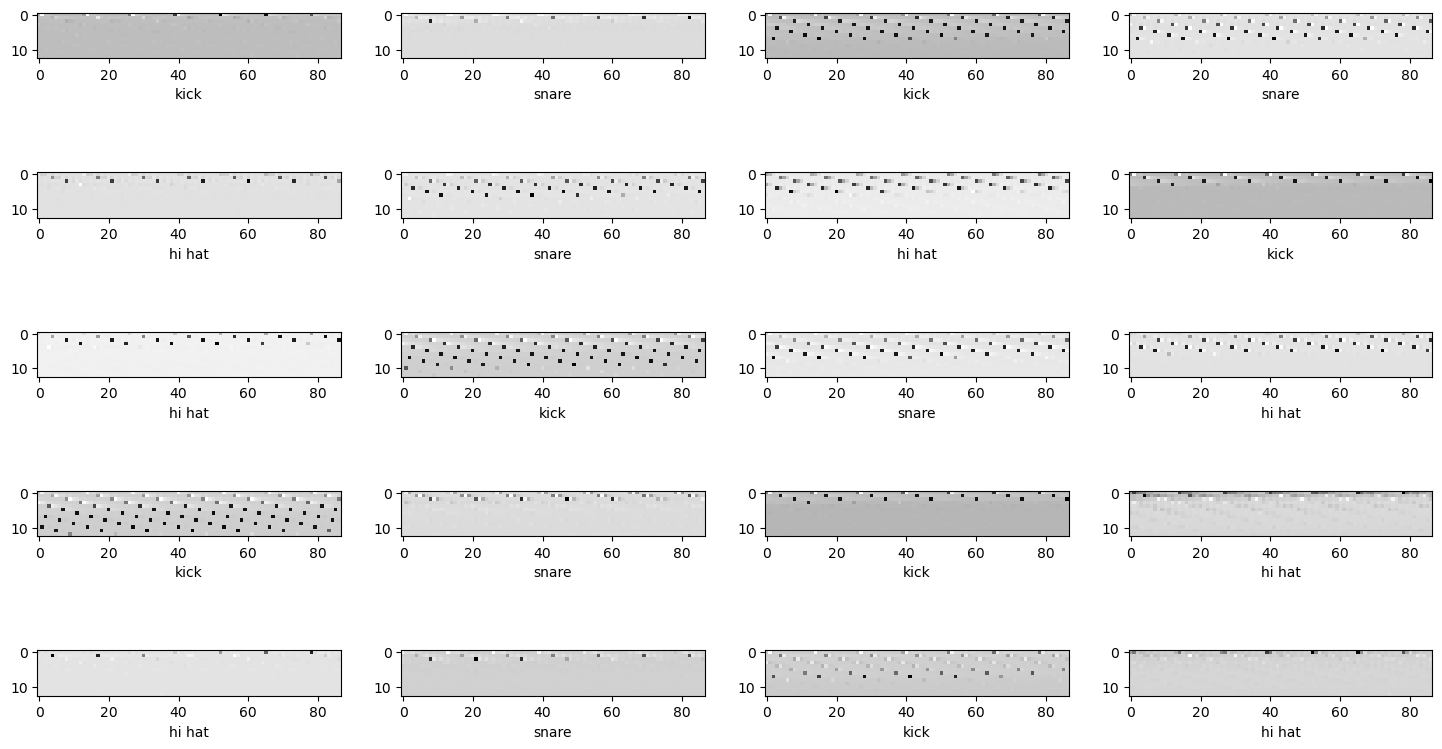

In [32]:
plot_data(X_train, y_train)
plot_data(X_train_rec, y_train)

## 2. Least Squares

In [76]:
class MyLinearRegression():
    W = None
    predictions = None
    method = None # 0 -> Closed Form, 1 -> Gradient Descent

    # arguements for gradient descent
    alpha = None
    num_iters = None

    error_history = None

    def __init__(self, method=0, alpha=0.01, num_iters=1500):
        self.method = method
        self.alpha = alpha
        self.num_iters = num_iters

    def closed_form(self, X, y):
        XT_X = np.dot(X.T, X) # X^T * X
        inv_XT_X = np.linalg.inv(XT_X) # (X^T * X)^-1
        w = np.dot(np.dot(inv_XT_X, X.T), y) # theta = (X^T * X)^-1 * X^T * y
        return w
    
    def computeCost(self, X, y, w): # for gradient descent
        return (1 / (2.0*X.shape[0])) * np.sum((( np.dot(X, w)-y)**2 ))
    
    def gradient_descent(self, X, y):
        # create the error history
        J_history = np.zeros((self.num_iters, 1))
        # set W to all zeros
        w = np.zeros((X.shape[1], y.shape[1]))

        # number of data inputs
        m = X.shape[0]

        for iter in range(self.num_iters):
            print(f"Iterations: [{iter} / {self.num_iters}]")

            cost = self.computeCost(X, y, w)
            new_w = np.zeros_like(w)

            # for each feature calculate its new weight
            for j in range(len(new_w)):
                Suma = 0
                for i in range(m):
                    Suma += (np.dot(w.T, X[i,:]) - y[i]) * X[i][j]
                new_w[j] = w[j] - (self.alpha / m) * Suma

            w = new_w

            # finished one iteration: add cost to history
            J_history[iter] = cost

        return (w, J_history)

    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X]) # add a column of 1s at the beginning
        if (self.method == 0): # closed form
            self.W = self.closed_form(X, y)
        elif (self.method == 1): # gradient descent
            self.W, self.error_history = self.gradient_descent(X, y)
        #print("Shape of weights:", self.W.shape)

    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X]) # add a column of 1s at the beginning
        self.predictions = np.dot(X, self.W)
        #print("Shape of predictions:", self.predictions.shape)

    def score(self, y):
        # extract predicted classes
        predicted_classes = np.argmax(self.predictions, axis=1)

        # measure accuracy
        true_labels = [np.where(onehot == 1)[0][0] for onehot in y]
        
        return np.mean(predicted_classes == true_labels)

### Testing our model

In [84]:
lin_reg = MyLinearRegression(method=0)
lin_reg.fit(X_train_pca, y_train)

# test on train data
lin_reg.predict(X_train_pca)
print("(Train) Accuracy:", lin_reg.score(y_train))

# test on test data
lin_reg.predict(X_test_pca)
print("(Test) Accuracy:", lin_reg.score(y_test))

(Train) Accuracy: 0.8081006685017695
(Test) Accuracy: 0.2676505783805345


### Testing with sklearn

In [83]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_pca, y_train)

# predict train data
y_preds_train = lr.predict(X_train_pca)
y_preds_train = np.argmax(y_preds_train, axis=1)
print("(Train) Accuracy:", np.mean(y_preds_train == np.argmax(y_train, axis=1)))

# predict test data
y_preds_test = lr.predict(X_test_pca)
y_preds_test = np.argmax(y_preds_test, axis=1)
print("(Test) Accuracy:", np.mean(y_preds_test == np.argmax(y_test, axis=1)))

(Train) Accuracy: 0.8081006685017695
(Test) Accuracy: 0.2676505783805345
